In [2]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.impute import KNNImputer


np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [3]:
#definizione di una funzione per leggere le colonne (abbastanza inutile)

def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

#definizione di una funzione per leggere i dati statistici di un df (abbastanza inutile)

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

#definizione 
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [4]:
apartments = pd.read_csv('apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


In [5]:
buildings = pd.read_csv('buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings
#describe_data(buildings, buildings_meta)

Loaded 6791 buildings


,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,96,0.0,55.891077,37.651583,2.0,Широкая улица,1К5,1980.0,3.0,16.0,0.0,1.0,1.0,1.0,1.0,0.0
6787,5857,0.0,55.821755,37.652930,2.0,улица Космонавтов,5,1989.0,3.0,9.0,0.0,1.0,0.0,NaN,0.0,0.0
6788,5218,0.0,55.600694,37.366484,11.0,улица Лаптева,4,2017.0,3.0,17.0,0.0,1.0,1.0,1.0,1.0,0.0
6789,1346,0.0,55.598817,37.360196,11.0,улица Москвитина,5к1,2016.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0


In [6]:
apartments.head()
apartments.shape

(23285, 19)

In [7]:
buildings.head()
buildings.shape

(6791, 16)

In [8]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data

All apartments have an associated building: True


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,23280,NaN,13300000.0,65.0,16.0,32.0,3.0,2.0,NaN,3.00,...,70к6,2017.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
23281,23281,3.0,15854300.0,56.9,9.6,36.5,6.0,2.0,NaN,NaN,...,2/2,2020.0,2.0,20.0,0.0,1.0,0.0,0.0,NaN,NaN
23282,23282,NaN,19800000.0,73.4,23.0,29.3,16.0,2.0,NaN,NaN,...,4,2018.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0,NaN
23283,23283,0.0,29999000.0,100.8,20.0,NaN,4.0,3.0,NaN,NaN,...,39К1,1997.0,2.0,10.0,0.0,1.0,1.0,0.0,NaN,0.0


In [13]:
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


 # Duplicated values

In [ ]:
#detect the possible duplicated values inside our dataset and delete them in the case (by comparing the shape before and then):

""" data.duplicated() """

0        False
1        False
2        False
3        False
4        False
         ...  
23280    False
23281    False
23282    False
23283    False
23284    False
Length: 23285, dtype: bool

In [ ]:
""" print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape) """

#same shape --> there weren't duplicated values inside the dataset.

(23285, 34)
(23285, 34)


In [ ]:
""" data_test.duplicated() """

0       False
1       False
2       False
3       False
4       False
        ...  
9932    False
9933    False
9934    False
9935    False
9936    False
Length: 9937, dtype: bool

In [ ]:
""" print(data_test.shape)
data_test.drop_duplicates(inplace=True)
print(data_test.shape)
 """
#same shape --> there weren't duplicated values inside the dataset.

(9937, 33)
(9937, 33)


DATA PREPROCESSING

array([[<AxesSubplot:title={'center':'seller'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'area_total'}>,
        <AxesSubplot:title={'center':'area_kitchen'}>,
        <AxesSubplot:title={'center':'area_living'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling'}>,
        <AxesSubplot:title={'center':'bathrooms_shared'}>,
        <AxesSubplot:title={'center':'bathrooms_private'}>],
       [<AxesSubplot:title={'center':'windows_court'}>,
        <AxesSubplot:title={'center':'windows_street'}>,
        <AxesSubplot:title={'center':'balconies'}>,
        <AxesSubplot:title={'center':'loggias'}>,
        <AxesSubplot:title={'center':'condition'}>],
       [<AxesSubplot:title={'center':'phones'}>,
        <AxesSubplot:title={'center':'building_id'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,


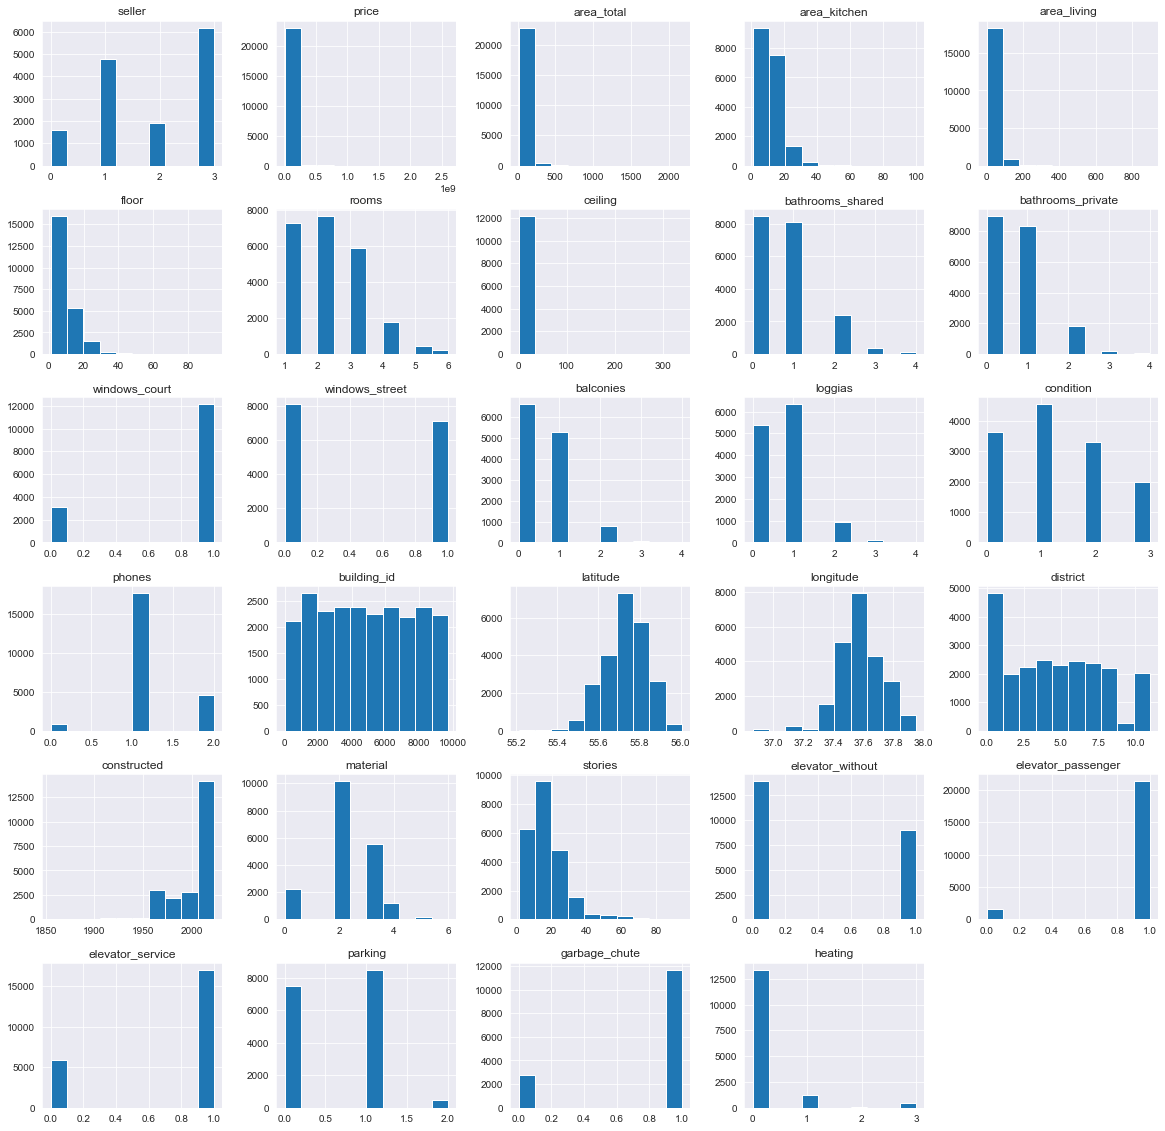

In [17]:
#plot the vertical bar chart for all the numerical attributes
# data.hist(figsize=(20,20))

# Missing values

In [12]:
#id feature is pointless for the analysis of the price since it changes for each sample
del data['id']
del data_test['id']


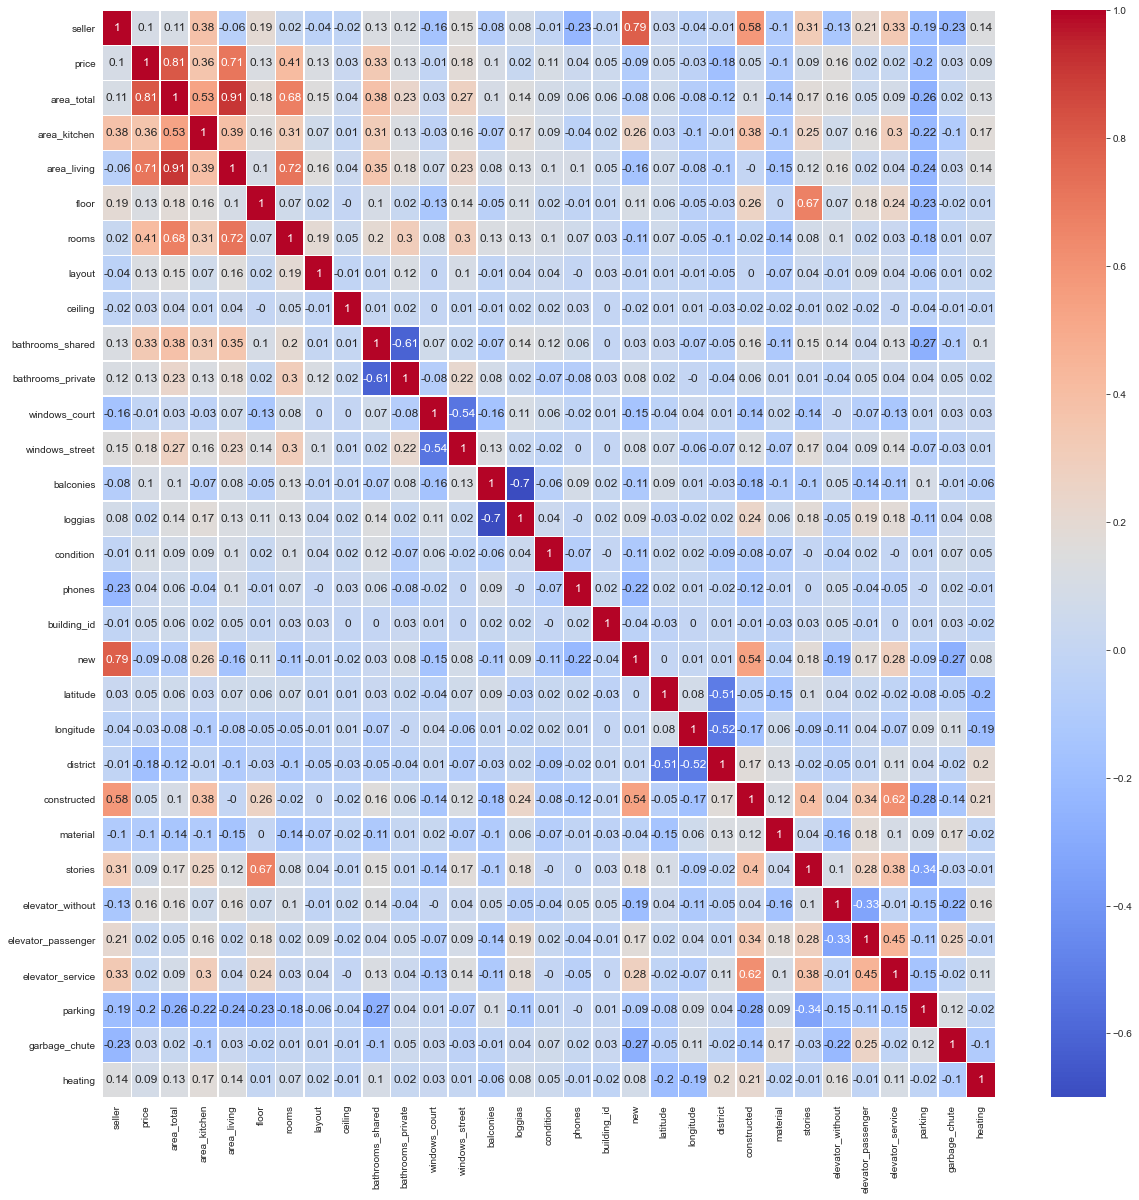

In [14]:
#heatmap
""" plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() """

In [15]:
#layout is pointless because for the largest number of the samples this features is NaN
del data['layout']
del data_test['layout']
#new is useless because its distribution is almost unique (boolean value = false) and it is not correlated with the price feature
del data['new']
del data_test['new']

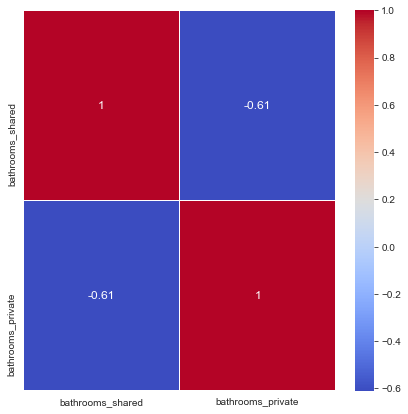

In [21]:
#firstly samples with NaN values for the features 'bathroom_shared' and 'bathroom_private' have been deleted and then the heatmap is displayed only for these two attributes
#bathroom_share is strongly correlated with bathroom_private: the coefficient is -0.61 (the correlation is inverse).
#so the feature 'bathrooms_shared' has been deleted. 
df = data[data['bathrooms_shared'].notna()]
df = df[df['bathrooms_private'].notna()]
prova=df[['bathrooms_shared','bathrooms_private']]
plt.figure(figsize = (7,7))
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()


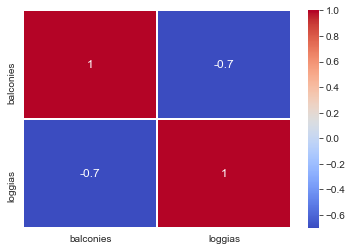

In [22]:
#firstly samples with NaN values for the features 'balconies' and 'loggias' have been deleted and then the heatmap is displayed only for these two attributes
#balconies is strongly correlated with loggias: the coefficient is -0.7(the correlation is inverse).
#so the feature 'loggias' has been deleted. 
df = data[data['balconies'].notna()]
df = df[df['loggias'].notna()]
prova=df[['balconies','loggias']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()


In [ ]:
prova = data.groupby('bathrooms_shared')['bathrooms_shared'].sum()
print(prova)

bathrooms_shared
0.0       0.0
1.0    8111.0
2.0    4734.0
3.0    1065.0
4.0     408.0
Name: bathrooms_shared, dtype: float64


In [ ]:
#detect if there are some missing values:

data.isnull().sum()

#there are a lot of missing values --> need to understand how to handle it

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

In [ ]:
#detect if there are some missing values:

data_test.isnull().sum()

#there are a lot of missing values --> need to understand how to handle it

id                       0
seller                3942
area_total               0
area_kitchen          2233
area_living           2019
floor                    0
rooms                    0
layout                7368
ceiling               5018
bathrooms_shared      1717
bathrooms_private     1717
windows_court         3488
windows_street        3488
balconies             4835
loggias               4835
condition             3959
phones                  40
building_id              0
new                    109
latitude                 2
longitude                2
district                25
street                   0
address                  0
constructed            374
material              1671
stories                  0
elevator_without       180
elevator_passenger     180
elevator_service       180
parking               2867
garbage_chute         3426
heating               3230
dtype: int64

In [ ]:
#sostituisco i NaN con il valore medio dei vicini (ho però il problema che non so se il NaN corrisponde alla mancanza del valore
#oppure alla mancanza dell'elemento considerato nell'appartamento, ma mi sembra strano che non ci sia una cucina o living room 
#figa, magari la soffitta già più probabile che non ci sia)
imputer = KNNImputer(n_neighbors=10)
data["area_kitchen"] = imputer.fit_transform(data[["area_kitchen"]]).ravel()
data["area_living"] = imputer.fit_transform(data[["area_living"]]).ravel()
data["ceiling"] = imputer.fit_transform(data[["ceiling"]]).ravel()

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen              0
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64